In [1]:
cd "/content/drive/My Drive/DL-ML/Submission/Semantic Segmentation"

/content/drive/My Drive/DL-ML/Submission/Semantic Segmentation


In [2]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from zipfile import ZipFile
import matplotlib.image as mimage
plt.style.use("ggplot")
%matplotlib inline

import keras
import tensorflow as tf
import keras.backend as kb
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
size=256   

Loading data

In [4]:
X=np.load("X_train_RGB_256.npy")  # X.shape = 1999x256x256x3
Y=np.load("Y_train_256_uint8.npy")  # Y.shape = 1999x256x256x11   as we have 11 classes hence one 256x256 binary map for each class

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=2018)  #train test split

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(1799, 256, 256, 3)
(1799, 256, 256, 11)
(200, 256, 256, 3)
(200, 256, 256, 11)


In [7]:
del X   # to avoid memory limit error
del Y  

Visualising data

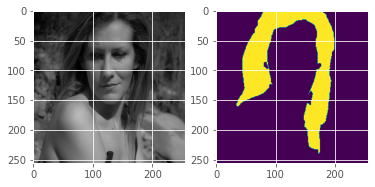

In [9]:
example_no=1
map_no = 10   # 10 is for hair....can try other values between 0-10
plt.subplot(1,2,1)
plt.imshow(X_train[example_no].reshape((size,size,3)))
plt.subplot(1,2,2)
plt.imshow(y_train[example_no,:,:,map_no])

Model

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
# Two conv layer with batch normalisation layer as optional. These blocks will be used to construct the model. 

In [11]:
#set parameters
im_width = 256
im_height = 256

In [12]:
def get_unet(input_img, n_filters=64, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(11, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),  # if model is not progressing early stopping is an option.
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),  # on plateau we can try decreasing the learning rate.
    #ModelCheckpoint('model.hdf5',mode='max', verbose=1,monitor="val_accuracy" ,save_best_only=True, save_weights_only=True)   # ModelCheckpoint can be used to save the best paramters while training...here we are monitoring the val_accuracy and hence this will save the parameters correspoding to min val_accuracy
]

In [14]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=False)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        activation_1[0][0]               
____________________________________________________________________________________________

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid,y_valid) ,shuffle=True,callbacks=callbacks)

Plotting learning curve

NameError: ignored

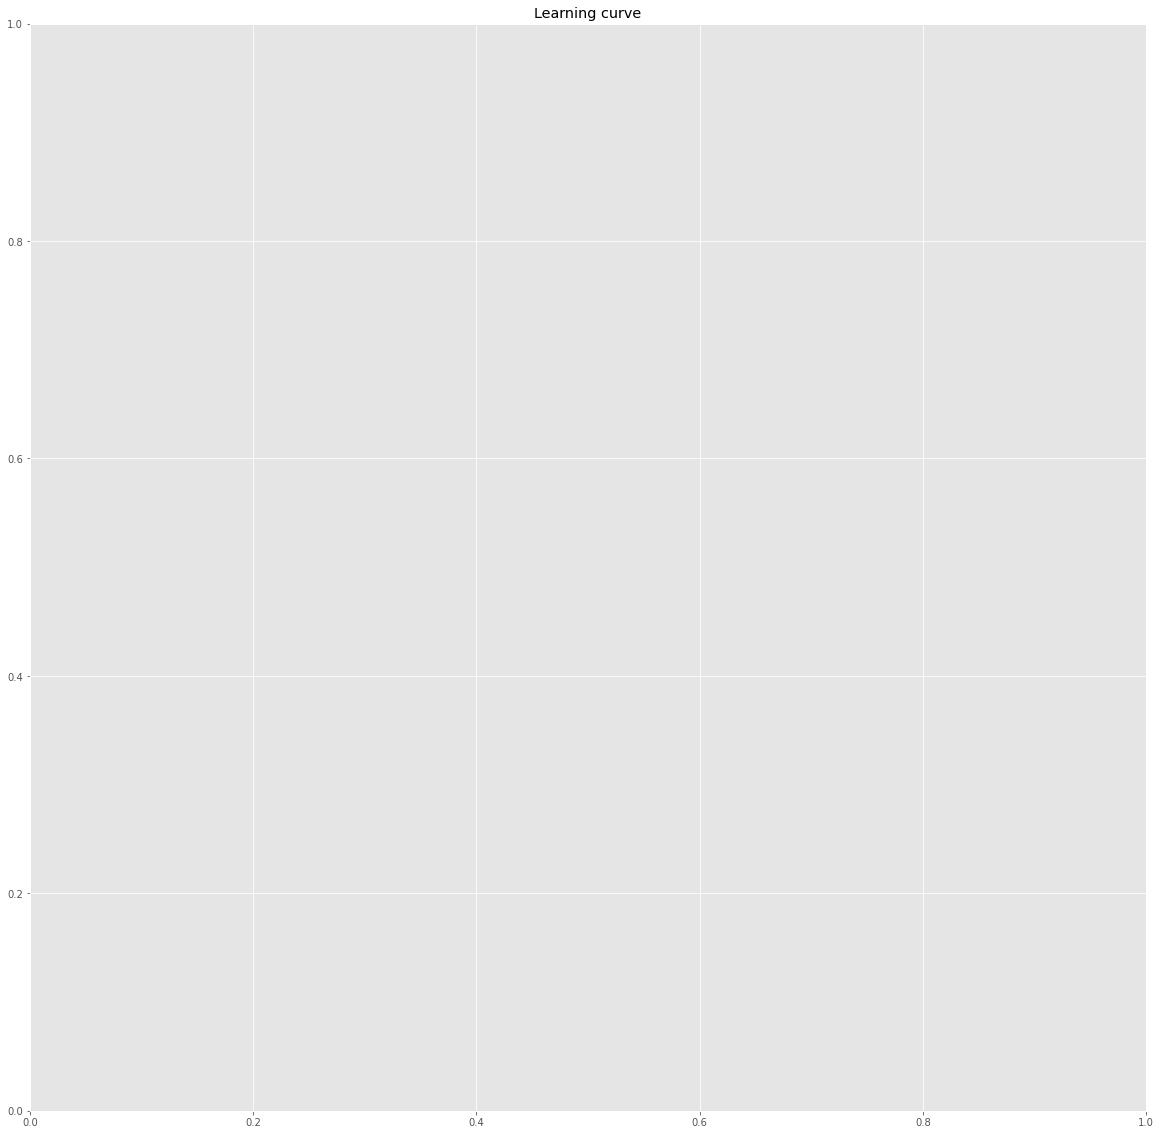

In [17]:
plt.figure(figsize=(20, 20))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xticks(np.arange(90,110,2),)
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Predictions

In [18]:
Y_test=np.load("Y_test_256.npy")
X_test=np.load("X_test_RGB_256.npy")

In [19]:
Y_pred=model.predict(X_test)

Save result in folder

In [20]:
with open("list_test.txt", 'r') as f:
    list_1 = [line.rstrip('\n') for line in f]                                                  # list_1 file contains name of images, necessary so that we can compare it with ground_truth for calculaation of F1_score

In [21]:
for i in range(len(list_1)):
  y_pred=np.argmax(Y_pred[i],2).reshape((size,size,1))
  y_pred=np.concatenate((y_pred,y_pred,y_pred),axis=2)       # Three times y_pred to create 256x256x3 image because ground_truth is also in same shape
  y_pred=y_pred.astype("uint8")
  plt.imsave("Pred_truth/{}.png".format(list_1[i][:-10]),y_pred)

Test set visualisation

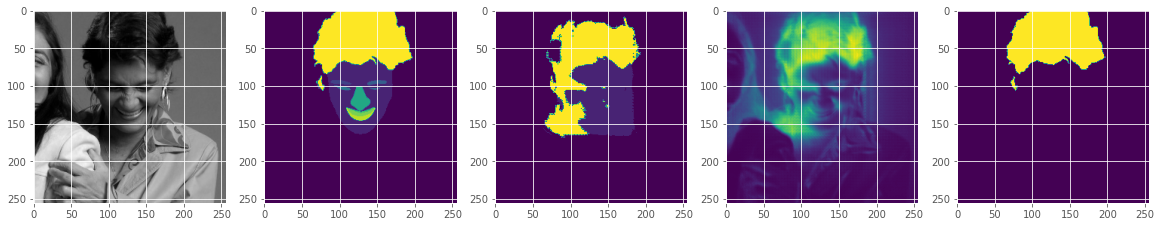

In [23]:
example_no=1
map_no = 10 

plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.imshow(X_test[example_no].reshape((size,size,3)))
plt.subplot(1,5,2)
plt.imshow(Y_test[example_no].reshape((size,size)))
plt.subplot(1,5,3)
plt.imshow(np.argmax(Y_pred[example_no],2).reshape((size,size)))
plt.subplot(1,5,4)
plt.imshow(Y_pred[example_no,:,:,map_no].reshape((size,size)))
plt.subplot(1,5,5)
plt.imshow(keras.utils.to_categorical(Y_test)[example_no,:,:,map_no].reshape((size,size)))

# first image -> RGB image, Second -> Predicted_segmentation_image, third -> Predicted segmnetation map, fourth -> groundtruth segmenation map

Custom Image test

In [ ]:
PATH = ""
map_no = 1
man=Image.open(PATH,mode="r").resize((size,size)) #change image path to your custom image
man=np.array(man).reshape(1,size,size,3)/255
man_y=model.predict(man)
plt.subplot(1,3,1)
plt.imshow(man.reshape(size,size,3),cmap="gray")
plt.subplot(1,3,2)
plt.imshow(np.argmax(man_y[0],axis=2).reshape(size,size))
plt.subplot(1,3,3)
plt.imshow(man_y[:,:,:,map_no].reshape((size,size)))
#first image -> RGB image #Second -> Segmentation image #third -> based on map_no different individual segmentation image

F1_score

In [24]:
import F1_Score

In [30]:
gt_dir="Ground_truth"          # Ground_truth folder
predicted_dir="Pred_truth"     # Pred_truth folder
label_dir="label_names.txt"    # I have attached the label_names.txt

In [ ]:
F1_Score.print_f1_score(gt_dir,predicted_dir,label_dir)